In [1]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

# sensor horizontal size
sensor_width = 7.75

# image file
laser = imageio.imread("laser-img/2025-09-07-012621-2mm-aperture.jpg")

In [2]:
dimensions = np.array([sensor_width * laser.shape[0] / laser.shape[1], sensor_width])
half_size = dimensions / 2

# Mean of all color channels as an approximation of the monochrome image
laser_monochrome = np.mean(laser, axis=2)
# Normalized intensity map
intensity_map = laser_monochrome / np.max(laser_monochrome)

# Summed intensity in each axis
intensity_x = np.sum(laser_monochrome, axis=0)
intensity_y = np.sum(laser_monochrome, axis=1)

# Center of mass of the laser beam
center = (
    (ndimage.center_of_mass(laser_monochrome) / np.array(laser_monochrome.shape) - 0.5)
    * dimensions
    * [-1, 1]
)
print(f"Center of the beam is at {center[0]:.3f}/{center[1]:.3f}")


# Calculate FWHM in each axis
def fwhm(curve, width):
    assert curve.ndim == 1
    half_max = (np.max(curve) + np.min(curve)) / 2
    diff = curve - half_max
    indices = np.where(diff > 0)[0]
    return (indices[-1] - indices[0]) / curve.size * width


fwhm_y = fwhm(intensity_y, dimensions[0])
fwhm_x = fwhm(intensity_x, dimensions[1])
print(f"FWHM in X/Y: {fwhm_x:.2f}/{fwhm_y:.2f}")

eccentricity = np.sqrt(1 - (min(fwhm_y, fwhm_x) ** 2 / max(fwhm_y, fwhm_x) ** 2))
print(f"Eccentricity (along cartesian axes): {eccentricity:.5f}")

Center of the beam is at -0.088/0.238
FWHM in X/Y: 2.16/1.46
Eccentricity (along cartesian axes): 0.73687


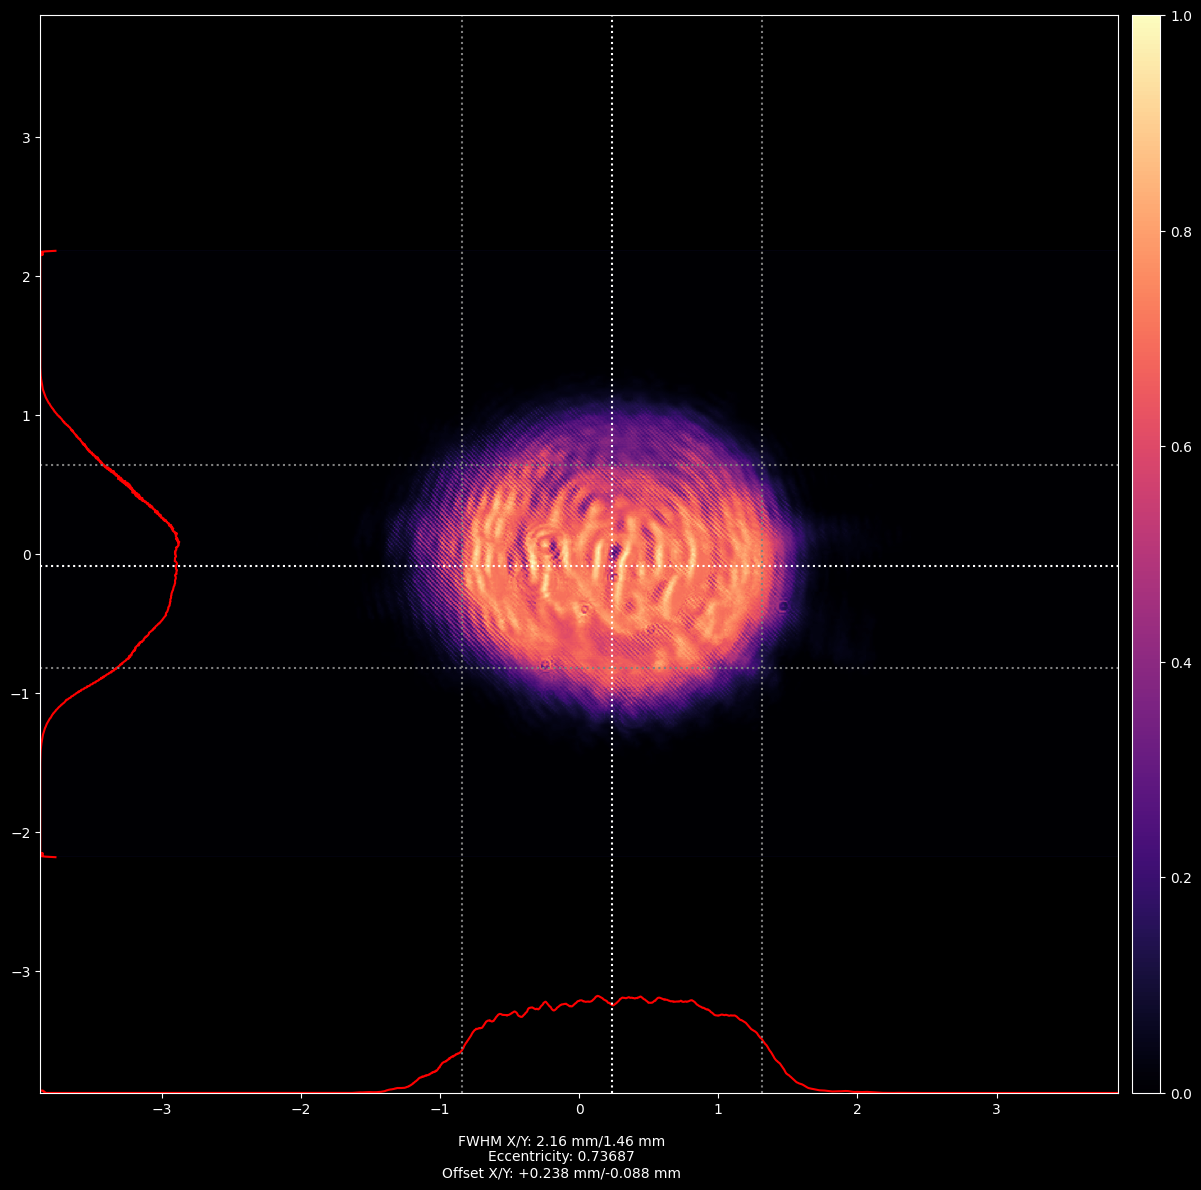

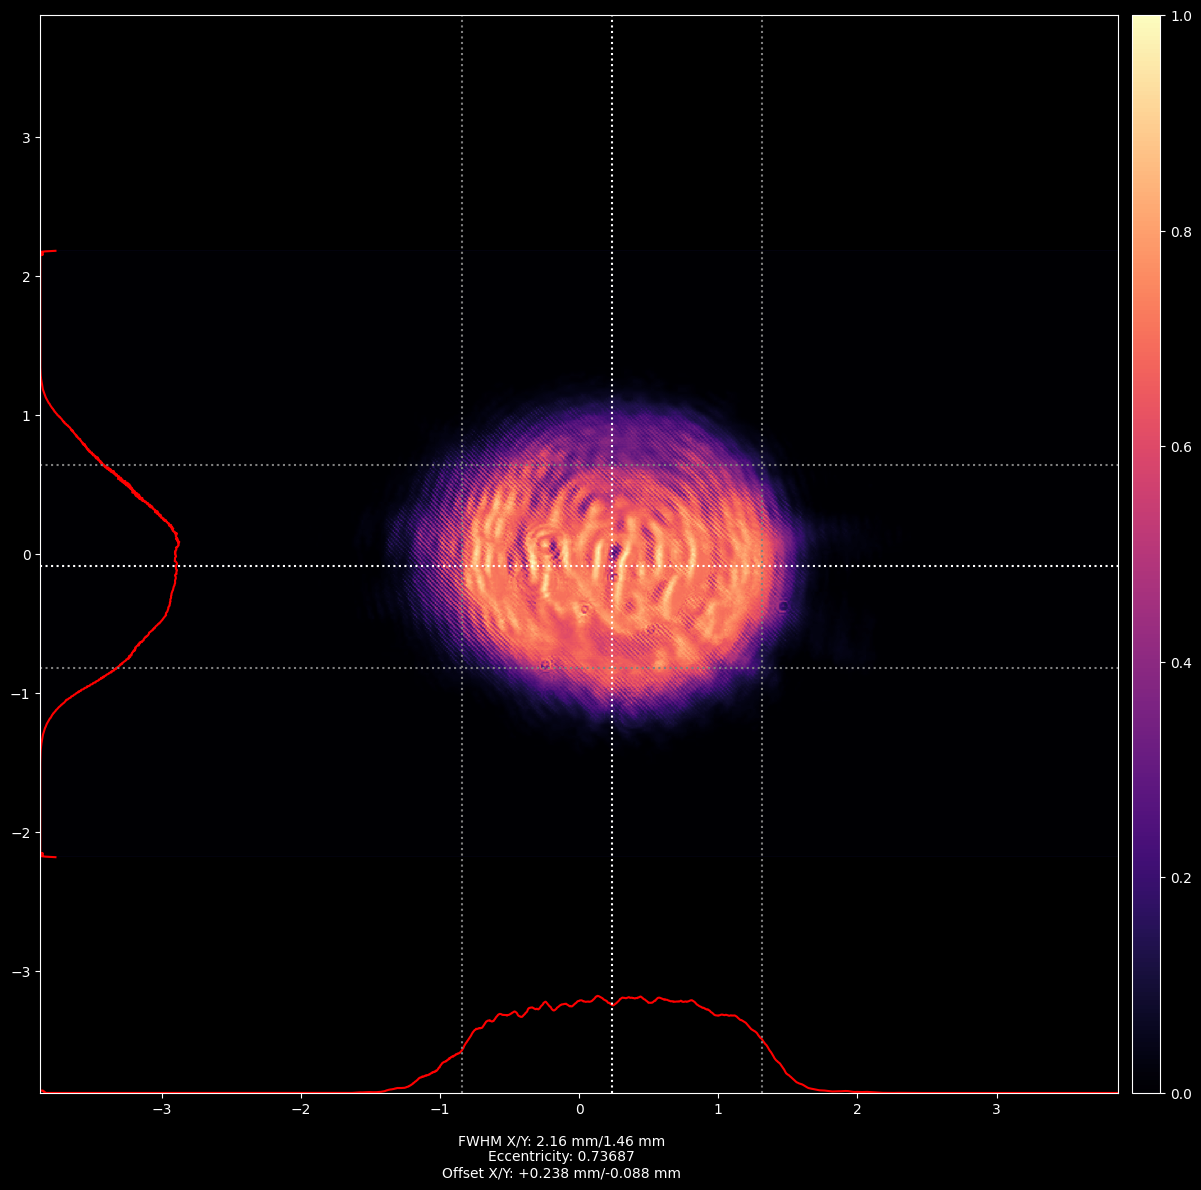

In [3]:
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(14, 14))
    im = ax.imshow(
        intensity_map,
        cmap="magma",
        extent=(-half_size[1], half_size[1], -half_size[0], half_size[0]),
        interpolation="none",
        vmin=0,
    )
    ax.set_xlim(-np.max(half_size), np.max(half_size))
    ax.set_ylim(-np.max(half_size), np.max(half_size))

    xy_scale = max(np.max(intensity_x), np.max(intensity_y))
    ax.plot(
        np.linspace(-half_size[1], half_size[1], intensity_x.size),
        intensity_x / xy_scale - np.max(half_size),
        color="red",
    )
    ax.plot(
        intensity_y / xy_scale - np.max(half_size),
        np.linspace(half_size[0], -half_size[0], intensity_y.size),
        color="red",
    )

    # reticle
    ax.axvline(x=center[1], color="white", linestyle=":")
    ax.axhline(y=center[0], color="white", linestyle=":")

    ax.axvline(x=center[1] - fwhm_x / 2, color="gray", linestyle=":")
    ax.axvline(x=center[1] + fwhm_x / 2, color="gray", linestyle=":")
    ax.axhline(y=center[0] - fwhm_y / 2, color="gray", linestyle=":")
    ax.axhline(y=center[0] + fwhm_y / 2, color="gray", linestyle=":")

    cax = fig.add_axes(
        [
            ax.get_position().x1 + 0.01,
            ax.get_position().y0,
            0.02,
            ax.get_position().height,
        ]
    )
    fig.colorbar(im, cax=cax)

    text = (
        f"FWHM X/Y: {fwhm_x:.2f} mm/{fwhm_y:.2f} mm\n"
        f"Eccentricity: {eccentricity:.5f}\n"
        f"Offset X/Y: {center[1]:+.3f} mm/{center[0]:+.3f} mm"
    )
    fig.text(0.5, 0.05, text, ha="center")

fig